In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


In [2]:
# assign FAST_RUN=True to train the model with three epochs
FAST_RUN = False

# input image dimensions
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# red, green and blue channels
IMAGE_CHANNELS=3

In [3]:
dataframe = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
dataframe.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

In [4]:
dataframe=dataframe.drop(labels=["patient_id","sex","age_approx","anatom_site_general_challenge","diagnosis","benign_malignant"],axis=1)
dataframe["image_name"]=dataframe["image_name"].apply(lambda x:x+".jpg")
dataframe.shape

(33126, 2)

In [5]:
benign_df=dataframe[dataframe.target==0].copy()
malignant_df = dataframe[dataframe.target==1].copy()

In [6]:
benign_df.head(3)

,image_name,target
0,ISIC_2637011.jpg,0
1,ISIC_0015719.jpg,0
2,ISIC_0052212.jpg,0


In [7]:
malignant_df.head(3)

,image_name,target
91,ISIC_0149568.jpg,1
235,ISIC_0188432.jpg,1
314,ISIC_0207268.jpg,1


In [8]:
train_benign,val_benign = train_test_split(benign_df,test_size=0.2,random_state=0)
train_malignant, val_malignant = train_test_split(malignant_df,test_size=0.2,random_state=0)
print(train_benign.shape[0])
print(val_benign.shape[0])
print(train_malignant.shape[0])
print(val_malignant.shape[0])

26033
6509
467
117


In [9]:
train_malignant_oversampled = train_malignant.copy()
val_malignant_oversampled = val_malignant.copy()

while(True):
    if train_malignant_oversampled.shape[0] > train_benign.shape[0]:
        break
    train_malignant_oversampled = pd.concat([train_malignant_oversampled,train_malignant])

while(True):
    if val_malignant_oversampled.shape[0] > val_benign.shape[0]:
        break
    val_malignant_oversampled = pd.concat([val_malignant_oversampled,val_malignant])
    
print(train_benign.shape[0])
print(val_benign.shape[0])
print(train_malignant_oversampled.shape[0])
print(val_malignant_oversampled.shape[0])

26033
6509
26152
6552


In [10]:
train_df = pd.concat([train_benign,train_malignant_oversampled])
val_df = pd.concat([val_benign,val_malignant_oversampled])
print(train_df.shape)
print(val_df.shape)

(52185, 2)
(13061, 2)


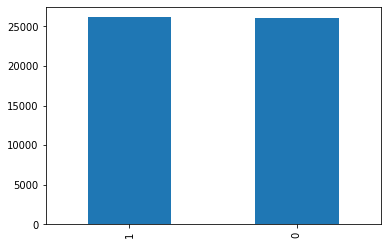

In [11]:
train_df['target'].value_counts().plot.bar()

In [12]:
# random.choice(train_df["image_name"].values)


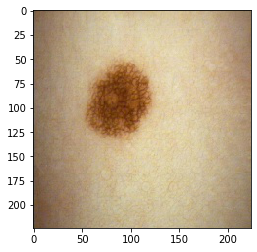

In [13]:
sample = random.choice(train_df["image_name"].values)
image = load_img("../input/siim-isic-melanoma-classification/jpeg2/train/"+sample)
plt.imshow(image)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#fully connected layer
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [16]:
!mkdir saved_model_3

mkdir: cannot create directory ‘saved_model_3’: File exists


In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
import os

class CustomSaver(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        if(os.path.isfile('saved_model_3/history.csv')!=True):
            history_df=pd.DataFrame(columns = ['loss','val_loss','accuracy','val_accuracy']) 
            history_df.to_csv('saved_model_3/history.csv',index=False)
        self.history_df = pd.read_csv('saved_model_3/history.csv')
        
    def on_epoch_end(self, epoch, logs={}):
        print("Epoch:",epoch)
        print("Loss:",logs["loss"],"Val_loss:",logs["val_loss"],"Accuracy:",logs["accuracy"],"Val_accuracy:",logs["val_accuracy"])
        self.model.save_weights("saved_model_3/model_"+str(self.history_df.shape[0])+".h5")
        print("Saved weights: "+"saved_model_3/model_"+str(self.history_df.shape[0])+".h5")
        self.history_df=self.history_df.append({'loss':logs["loss"],
                   'val_loss':logs['val_loss'],
                   'accuracy':logs['accuracy'],
                   'val_accuracy':logs['val_accuracy']},ignore_index = True)
        self.history_df.to_csv('saved_model_3/history.csv',index=False)
         
saver = CustomSaver()

In [19]:
callbacks = [earlystop, learning_rate_reduction,saver]

In [20]:
train_df["target"] = train_df["target"].replace({0: 'benign', 1: 'malignant'}) 
val_df["target"] = val_df["target"].replace({0: 'benign', 1: 'malignant'}) 

In [21]:
train_df.head(5)

,image_name,target
19144,ISIC_5809628.jpg,benign
11364,ISIC_3500137.jpg,benign
8017,ISIC_2497305.jpg,benign
4969,ISIC_1592874.jpg,benign
3291,ISIC_1092935.jpg,benign


In [22]:
train_df = train_df.reset_index(drop=True)
validate_df = val_df.reset_index(drop=True)

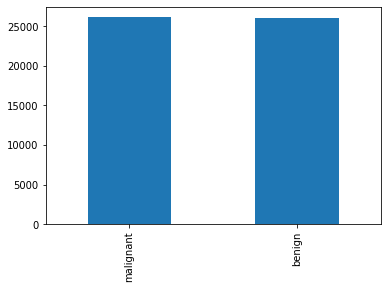

In [23]:
train_df['target'].value_counts().plot.bar()

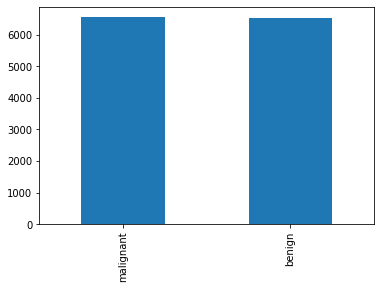

In [24]:
validate_df['target'].value_counts().plot.bar()

In [25]:
# get the total amount of data in train and validation set
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# set the minibatch size to 15
batch_size=15

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=360,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/siim-isic-melanoma-classification/jpeg2/train/", 
    x_col='image_name',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 52185 validated image filenames belonging to 2 classes.


In [28]:
validation_datagen = ImageDataGenerator(
    rotation_range=360,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/siim-isic-melanoma-classification/jpeg2/train/",
    x_col='image_name',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 13061 validated image filenames belonging to 2 classes.


In [29]:
# here we will create a dataframe with one row from the training dataframe for demonstrating
# how the datagenerator works
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/siim-isic-melanoma-classification/jpeg2/train/", 
    x_col='image_name',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


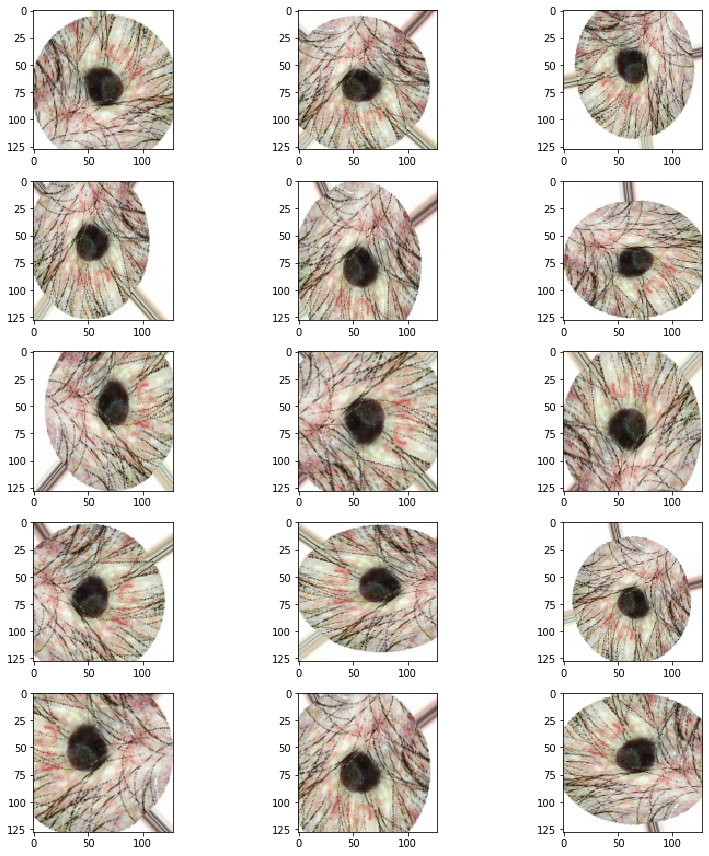

In [30]:
# we will generate 15 random image from our example data generator and show them using
# matplotlib
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    #on each iteration of the for loop, the generator returns the same amount of random 
    #images as the original dataframe on which the generator was created
    for X_batch, Y_batch in example_generator:
        #get the first image of the generated batch
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [31]:
epochs=3 if FAST_RUN else 50

In [44]:
if(os.path.isfile('saved_model_3/history.csv') and pd.read_csv('saved_model_3/history.csv').shape[0]>0):
    iteration_to_be_loaded=pd.read_csv('saved_model_3/history.csv').shape[0]-1
    model.load_weights("saved_model_3/model_"+str(iteration_to_be_loaded)+".h5")
    print("saved_model_3/model_"+str(iteration_to_be_loaded)+".h5"+" loaded!")

saved_model_3/model_12.h5 loaded!


In [45]:
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3479 steps, validate for 870 steps
Epoch 1/50
3478/3479 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8126Epoch: 0
Loss: 0.40892603979923836 Val_loss: 0.6617695631480766 Accuracy: 0.8125898 Val_accuracy: 0.7807663
Saved weights: saved_model_3/model_13.h5
3479/3479 [==============================] - 320s 92ms/step - loss: 0.4089 - accuracy: 0.8126 - val_loss: 0.6618 - val_accuracy: 0.7808
Epoch 2/50
3478/3479 [============================>.] - ETA: 0s - loss: 0.4073 - accuracy: 0.8131Epoch: 1
Loss: 0.4072829652540161 Val_loss: 0.6181443719343207 Accuracy: 0.8131264 Val_accuracy: 0.78122604
Saved weights: saved_model_3/model_14.h5
3479/3479 [==============================] - 343s 99ms/step - loss: 0.4073 - accuracy: 0.8131 - val_loss: 0.6181 - val_accuracy: 0.7812
Epoch 3/50
3478/3479 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8169Epoch: 2
Loss: 0.40345752483154035 Val_loss:

/home/mahathir/miniconda3/envs/machine/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/mahathir/miniconda3/envs/machine/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


KeyError: 'val_loss'

In [46]:
results=pd.read_csv('saved_model_3/history.csv')

In [48]:
results

,loss,val_loss,accuracy,val_accuracy
0,0.590323,0.880676,0.711047,0.497625
1,0.518839,0.642322,0.745176,0.668506
2,0.497375,0.509736,0.759720,0.759770
3,0.483998,1.093655,0.766063,0.598391
4,0.476200,0.868311,0.771275,0.632950
5,0.450031,0.539917,0.788023,0.779693
6,0.445835,0.571761,0.791377,0.768966
7,0.439187,0.624379,0.794884,0.781379
8,0.435015,0.657251,0.797202,0.756322
9,0.432861,0.527135,0.798448,0.795096


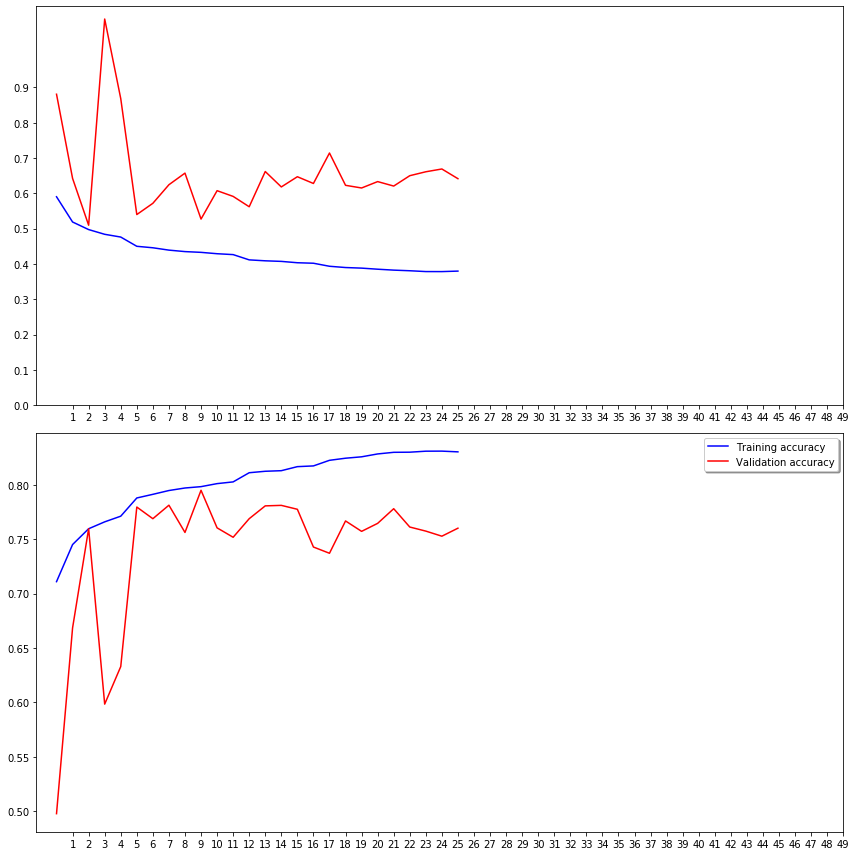

In [49]:
# create a figure with two subplots in 2 rows and one column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

#draw losses on the first subplot
# plot the training loss
ax1.plot(results['loss'], color='b', label="Training loss")
#plot the validation loss
ax1.plot(results['val_loss'], color='r', label="validation loss")

ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

#draw accuracy on the second subplot
# training accuracy
ax2.plot(results['accuracy'], color='b', label="Training accuracy")
# validation accuracy
ax2.plot(results['val_accuracy'], color='r',label="Validation accuracy")

ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [83]:
iteration_to_be_loaded = 25
model.load_weights("saved_model_3/model_"+str(iteration_to_be_loaded)+".h5")

In [84]:
test_filenames = os.listdir("../input/siim-isic-melanoma-classification/jpeg2/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

10982

In [85]:
test_gen = ImageDataGenerator(rescale=1./255)

#remember to not shuffle the test set
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/siim-isic-melanoma-classification/jpeg2/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 10982 validated image filenames.


In [86]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [87]:
print(predict.shape)
predict

(10982, 2)


array([[0.7969521 , 0.20304789],
       [0.9933303 , 0.00666963],
       [0.98983544, 0.01016454],
       ...,
       [0.7657139 , 0.23428616],
       [0.7061133 , 0.29388675],
       [0.3579739 , 0.6420261 ]], dtype=float32)

In [88]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())

In [89]:
label_map

{0: 'benign', 1: 'malignant'}

In [90]:
predict[:,1]

array([0.20304789, 0.00666963, 0.01016454, ..., 0.23428616, 0.29388675,
       0.6420261 ], dtype=float32)

In [91]:
test_df['category']=predict[:,1]

In [92]:
test_df

,filename,category
0,ISIC_2951472.jpg,0.203048
1,ISIC_0306094.jpg,0.006670
2,ISIC_9414809.jpg,0.010165
3,ISIC_1964724.jpg,0.269284
4,ISIC_0547086.jpg,0.000724
...,...,...
10977,ISIC_1979700.jpg,0.004928
10978,ISIC_8328232.jpg,0.003945
10979,ISIC_9937768.jpg,0.234286
10980,ISIC_1608729.jpg,0.293887


In [93]:
submission_df = test_df.copy()
# image_name,target
submission_df['image_name'] = submission_df['filename'].str.split('.').str[0]
submission_df['target'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
# I added this line
# submission_df=submission_df.astype({'id': 'int32'})
# submission_df=submission_df.sort_values('id',ascending=True)

submission_df.to_csv('submission.csv', index=False)